## Entendimento do Negócio

O presente projeto objetiva prever a temperatura média de janeiro/23 com base nos dados meteorológicos de janeiro/22 a dezembro/22 da cidade de São Paulo. Para isso, será utilizado um conjunto de dados da Open-Meteo, uma API que possui diversas informações que podem ser consumidas livremente a respeito do clima de diversos locais. Ademais, segue abaixo a descrição de cada variável utilizada no projeto.


| Atributo | Datatype | Descrição | Exemplo |
| -------- | :------: | --------- | :------: | 
| Date | DateTime | Date and time from data extraction | 2022-01-01 03:00:00 |
| Weathercode | Float | Weather condition as a numeric code. Follow WMO weather interpretation codes. See table below for details. | 63.00 |
| Temperature_2m_max | Float | Maximum daily air temperature at 2 meters above ground | 42.50 |
| Temperature_2m_min | Float | Minimum daily air temperature at 2 meters above ground | 12.70 |
| Temperature_2m_mean | Float | Average daily air temperature at 2 meters above ground | 27.50 |
| Apparent_temperature_max | Float | Maximum daily apparent temperature | 37.50 |
| Apparent_temperature_min | Float | Minimum daily apparent temperature | 14.90 |
| Apparent_temperature_mean | Float | Average daily apparent temperature | 29.30 |
| Sunrise | Int | Sunrise datetime in iso8601 format | 2022-01-01T05:22 |
| Sunset | Int | Sunset datetime in iso8601 format | 2023-01-01T18:58 |
| Shortwave_radiation_sum | Float | The sum of solar radiation on a given day in Megajoules | 22.50 |
| Precipitation_sum | Float | Sum of daily precipitation (including rain, showers and snowfall) | 8.20 |
| Rain_sum | Float | Sum of daily rain | 5.75 |
| Snowfall_sum | Float | Sum of daily snowfall | 7.85 |
| Precipitation_hours | Float | The number of hours with rain | 6.50 |
| Wind_speed_10m_max | Float | Maximum wind speed on a day | 10.00 |
| Wind_gusts_10m_max | Float | Maximum gusts speed on a day | 10.00 |
| Wind_direction_10m_dominant | Float | Dominant wind direction | 315.20 |
| Et0_fao_evapotranspiration | Float | ET₀ Reference Evapotranspiration of a well watered grass field. Based on FAO-56 Penman-Monteith equations ET₀ is calculated from temperature, wind speed, humidity and solar radiation. Unlimited soil water is assumed. ET₀ is commonly used to estimate the required irrigation for plants | 10.00 |


Fonte das informações: https://open-meteo.com/en/docs

___

## Entendimento e Pré-Processamento dos Dados

Nesta seção será realiza a exploração do conjunto de dados, ou seja, a etapa na qual iremos validar a presença de valores nulos, informações que não correspondem as regras definidas no metadados e medidas estatisticas para formulação de hipóteses em relação a variável alvo. Além disso, também será realizado o pré-processamento dos dados, a fim de converter as variáveis categóricas em numéricas para serem consideradas no modelo.

Etapa 00 - Importação das bibliotecas que serão utilizadas no projeto

In [173]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

Etapa 01 - Importar o conjunto de dados de treino, renomear campos que possuam números em seu texto e visualizar os primeiros registros

In [174]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": -23.5489,
	"longitude": -46.6388,
	"start_date": "2022-01-01",
	"end_date": "2022-12-31",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
	"timezone": "America/Sao_Paulo"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]

daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
daily_sunrise = daily.Variables(7).ValuesAsNumpy()
daily_sunset = daily.Variables(8).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(9).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(10).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(11).ValuesAsNumpy()
daily_rain_sum = daily.Variables(12).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(13).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(14).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(15).ValuesAsNumpy()
daily_wind_gusts_10m_max = daily.Variables(16).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(17).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(18).ValuesAsNumpy()
daily_et0_fao_evapotranspiration = daily.Variables(19).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

train_dataset = pd.DataFrame(data = daily_data)
train_dataset.head(10)

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2022-01-01 03:00:00,63.0,24.962000,17.712000,21.074499,26.744705,19.100561,22.874990,0,0,...,30758.074219,15.800000,15.800000,0.0,15.0,24.774696,42.119999,331.917603,19.969999,3.566301
1,2022-01-02 03:00:00,63.0,26.962000,19.762001,22.345335,31.676796,22.138430,25.236937,0,0,...,35997.191406,11.300000,11.300000,0.0,11.0,13.397612,30.239998,351.899231,21.090000,4.124883
2,2022-01-03 03:00:00,65.0,27.362000,19.162001,22.199495,31.636505,21.589767,25.096375,0,0,...,29965.804688,19.400003,19.400003,0.0,11.0,18.345877,31.680000,53.405457,20.500000,3.892584
3,2022-01-04 03:00:00,63.0,25.862000,19.512001,22.512001,29.291679,21.811171,24.695677,0,0,...,36612.542969,18.700001,18.700001,0.0,14.0,23.933907,43.560001,355.472687,21.730000,3.977374
4,2022-01-05 03:00:00,61.0,25.962000,20.462000,22.222414,27.708101,21.032681,23.531364,0,0,...,18338.859375,7.300000,7.300000,0.0,14.0,24.149532,45.360001,325.862579,13.220000,2.603215
5,2022-01-06 03:00:00,63.0,26.662001,19.262001,21.232834,31.307304,20.475950,22.816681,0,0,...,21790.574219,12.700001,12.700001,0.0,21.0,23.141029,38.880001,236.044907,17.549999,3.163469
6,2022-01-07 03:00:00,61.0,22.862000,18.212000,19.574501,24.706306,18.628096,20.111567,0,0,...,16533.980469,9.400002,9.400002,0.0,22.0,24.023088,39.959999,156.381851,15.460000,2.530865
7,2022-01-08 03:00:00,61.0,22.062000,16.862000,18.989084,22.665800,16.993170,19.020212,0,0,...,12741.221680,3.200000,3.200000,0.0,11.0,26.260265,42.839996,140.694061,13.990000,2.352128
8,2022-01-09 03:00:00,53.0,20.462000,16.011999,18.343250,19.898697,17.131838,18.364668,0,0,...,4895.560059,1.800000,1.800000,0.0,10.0,23.419376,39.599998,134.702789,10.710000,1.880359
9,2022-01-10 03:00:00,51.0,24.012001,15.912001,19.472416,26.133261,17.206211,21.088573,0,0,...,9701.313477,1.500000,1.500000,0.0,8.0,13.708390,22.319998,126.375740,12.820000,2.533231


Etapa 02 - Verificando os tipos de dados de cada variável do conjunto de dados


Todas as features possuem o mesmo tipo de dados apresentado na seção "Entendimento do Negócio"

In [175]:
train_dataset.dtypes

date                           datetime64[ns]
weather_code                          float32
temperature_2m_max                    float32
temperature_2m_min                    float32
temperature_2m_mean                   float32
apparent_temperature_max              float32
apparent_temperature_min              float32
apparent_temperature_mean             float32
sunrise                                 int64
sunset                                  int64
daylight_duration                     float32
sunshine_duration                     float32
precipitation_sum                     float32
rain_sum                              float32
snowfall_sum                          float32
precipitation_hours                   float32
wind_speed_10m_max                    float32
wind_gusts_10m_max                    float32
wind_direction_10m_dominant           float32
shortwave_radiation_sum               float32
et0_fao_evapotranspiration            float32
dtype: object

Etapa 03 - Verificar a presença de valores nulos e/ou que não atendam as regras definidas no metadados

Nenhuma das 21 variáveis apresentadas para os 365 registro são nulas, portanto, podemos seguir com as análises

In [176]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         365 non-null    datetime64[ns]
 1   weather_code                 365 non-null    float32       
 2   temperature_2m_max           365 non-null    float32       
 3   temperature_2m_min           365 non-null    float32       
 4   temperature_2m_mean          365 non-null    float32       
 5   apparent_temperature_max     365 non-null    float32       
 6   apparent_temperature_min     365 non-null    float32       
 7   apparent_temperature_mean    365 non-null    float32       
 8   sunrise                      365 non-null    int64         
 9   sunset                       365 non-null    int64         
 10  daylight_duration            365 non-null    float32       
 11  sunshine_duration            365 non-null    

Etapa 04 - Visualizando as principais métricas estatísticas do conjunto de dados, como por exemplo: quantidade, média, desvio padrão, valor mínimo, quartís e valor máximo

O valor "NaN" apresentado para a feature "date" no desvio padrão (ou "std") ocorreu pois o tipo de dado não é numérico, logo não é possível calcular o desvio padrão

In [177]:
train_dataset.describe()

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.0,...,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2022-07-02 03:00:00,38.857533,24.510494,15.121863,18.985344,25.547806,15.116573,19.393122,0.0,0.0,...,30615.634766,3.924384,3.924384,0.0,5.342466,19.769941,34.259178,169.831192,17.781918,3.421818
min,2022-01-01 03:00:00,0.000000,13.362000,5.712000,9.766167,6.391571,0.407548,3.611836,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,8.534353,12.959999,1.373242,3.550000,0.796768
25%,2022-04-02 03:00:00,3.000000,22.012001,12.612000,16.976583,21.925041,11.556856,16.456276,0.0,0.0,...,25928.693359,0.000000,0.000000,0.0,0.000000,16.622490,29.519999,100.417122,13.930000,2.560769
50%,2022-07-02 03:00:00,51.000000,24.962000,15.262000,19.253666,25.835966,15.305342,19.144693,0.0,0.0,...,35266.160156,0.700000,0.700000,0.0,3.000000,19.386593,34.200001,130.271988,17.260000,3.399185
75%,2022-10-01 03:00:00,61.000000,27.212000,17.762001,21.501585,29.935650,18.968098,23.304865,0.0,0.0,...,38216.332031,5.299999,5.299999,0.0,9.000000,23.000591,38.880001,282.331116,22.549999,4.360532
max,2022-12-31 03:00:00,65.000000,32.062000,20.912001,24.870333,35.975880,23.350708,27.503990,0.0,0.0,...,45788.753906,40.200001,40.200001,0.0,24.000000,42.737019,69.839996,358.973328,31.650000,6.151287
std,NaN,26.184185,3.817499,3.304916,3.155771,5.411492,4.726508,4.604804,0.0,0.0,...,11885.967773,6.491003,6.491003,0.0,5.916588,5.130767,8.115570,104.446236,6.030947,1.205060


Etapa 05 - Realizando o encoding da variável "date" visto que é categórica e precisa ser numérica para que o modelo de regressão linear interprete corretamente o dado

In [178]:
def encoding(feature):
    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder()
    train_dataset[feature]= label_encoder.fit_transform(train_dataset[feature])
    train_dataset[feature].unique()

encoding("date")

Etapa 06 - Investigando a correlação entre as variáveis independentes e dependente

Nem sempre plotar o dataframe de correlação é a melhor escolha, portanto, vale utilizar o método "sort_values" para ordenar o índice de correlação das variáveis independentes com a variável dependente. Além disso, como podemos ver nos resultados, algumas variáveis como "sunshine_duration", "weather_code", "precipitation_sum", "rain_sum", "wind_direction_10m_dominant", "precipitation_hours", "wind_gusts_10m_max", "wind_speed_10m_max", "date", "sunrise", "sunset" e "snowfall_sum" apresentaram baixa correlação com a variável dependente, o que pode vir a influênciar menos na predição da temperatura média

In [179]:
correlation = train_dataset.corr()

correlation.sort_values(["temperature_2m_mean"], ascending = False, inplace = True)

print(f"Features ordenadas por ordem de correlação com a variável dependente\n\n{correlation['temperature_2m_mean']}")

Features ordenadas por ordem de correlação com a variável dependente

temperature_2m_mean            1.000000
apparent_temperature_mean      0.979195
apparent_temperature_max       0.904171
apparent_temperature_min       0.895715
temperature_2m_min             0.894074
temperature_2m_max             0.893831
et0_fao_evapotranspiration     0.648876
shortwave_radiation_sum        0.502392
daylight_duration              0.502094
sunshine_duration              0.315254
weather_code                   0.272045
precipitation_sum              0.233876
rain_sum                       0.233876
wind_direction_10m_dominant    0.181767
precipitation_hours            0.124455
wind_gusts_10m_max             0.002121
wind_speed_10m_max            -0.081492
date                          -0.311773
sunrise                             NaN
sunset                              NaN
snowfall_sum                        NaN
Name: temperature_2m_mean, dtype: float64


___

## Treinamento dos Modelos

Nesta seção será realizado o treinamento do modelo. Vale ressaltar que, como primeira tentativa, o modelo será treinado com todas as variáveis do conjunto de treinamento, porém, em uma tentativa de otimizar a performance, podem ser necessários a realização de segundos ou terceiros treinamentos.

Etapa 06 - Realizando o primeiro treinamento do modelo


Como apresentado abaixo, o conjunto de dados pode ser representado por uma equação linear, visto que o R-Squared, ou Coeficiente de Relação, é igual a 1 (um) . Por outro lado, ao analisar os p-values ou valor da estatística de teste maior ou igual ao encontrado, notamos que diversas features apresentam um valor maior que 0.05. Sendo assim, realizaremos um segundo treinamento, considerando apenas as variáveis onde o p-value <= 0.05, a fim de observar se haverá alguma mudança no valor do coeficiente de relação. Portanto, as variáveis "date", "weather_code", "precipitation_hours", "wind_gusts_10m_max" e "wind_direction_10m_dominant" serão desconsideradas no próximo treinamento.

In [180]:
x = train_dataset[["date", "weather_code", "temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]]
y = train_dataset["temperature_2m_mean"]
model_one = sm.OLS(y, x).fit()
print(model_one.summary())

                                 OLS Regression Results                                 
Dep. Variable:     temperature_2m_mean   R-squared (uncentered):                   1.000
Model:                             OLS   Adj. R-squared (uncentered):              1.000
Method:                  Least Squares   F-statistic:                          1.794e+05
Date:                 Sat, 18 Nov 2023   Prob (F-statistic):                        0.00
Time:                         18:41:22   Log-Likelihood:                          47.961
No. Observations:                  365   AIC:                                     -63.92
Df Residuals:                      349   BIC:                                     -1.525
Df Model:                           16                                                  
Covariance Type:             nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------

Etapa 07 - Realizando o segundo treinamento do modelo

Note que após o segundo treinamento do modelo, o R-Squared (ou Coeficiente de Relação) permaneceu inalterado, entretanto, a variável "snowfall_sum" apresentou o p-value igual a "NaN". Neste caso em particular, visto que não há registros de neve em São Paulo, a variável será desconsiderada no terceiro treinamento do modelo.

In [181]:
x = train_dataset[["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]]
y = train_dataset["temperature_2m_mean"]
model_two = sm.OLS(y, x).fit()
print(model_two.summary())

                                 OLS Regression Results                                 
Dep. Variable:     temperature_2m_mean   R-squared (uncentered):                   1.000
Model:                             OLS   Adj. R-squared (uncentered):              1.000
Method:                  Least Squares   F-statistic:                          2.636e+05
Date:                 Sat, 18 Nov 2023   Prob (F-statistic):                        0.00
Time:                         18:41:22   Log-Likelihood:                          47.202
No. Observations:                  365   AIC:                                     -72.40
Df Residuals:                      354   BIC:                                     -29.51
Df Model:                           11                                                  
Covariance Type:             nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

Etapa 08 - Realizando o terceiro treinamento do modelo

Somente as variáveis de interesse foram utilizadas para realizar o treinamento, portanto, podemos seguir para a etapa de predição das temperaturas médias.

In [182]:
x = train_dataset[["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "wind_speed_10m_max", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]]
y = train_dataset["temperature_2m_mean"]
model_three = sm.OLS(y, x).fit()
print(model_three.summary())

                                 OLS Regression Results                                 
Dep. Variable:     temperature_2m_mean   R-squared (uncentered):                   1.000
Model:                             OLS   Adj. R-squared (uncentered):              1.000
Method:                  Least Squares   F-statistic:                          2.636e+05
Date:                 Sat, 18 Nov 2023   Prob (F-statistic):                        0.00
Time:                         18:41:22   Log-Likelihood:                          47.202
No. Observations:                  365   AIC:                                     -72.40
Df Residuals:                      354   BIC:                                     -29.51
Df Model:                           11                                                  
Covariance Type:             nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

___

## Predição dos Modelos

Nesta seção será realizada a predição da temperatura média com todos os modelos treinados anteriormente.

Etapa 09 - Importando os dados de teste, ou seja, capturando todas as informações de janeiro de 2023

In [183]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": -23.5489,
	"longitude": -46.6388,
	"start_date": "2023-01-01",
	"end_date": "2023-01-31",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
	"timezone": "America/Sao_Paulo"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]

daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
daily_sunrise = daily.Variables(7).ValuesAsNumpy()
daily_sunset = daily.Variables(8).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(9).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(10).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(11).ValuesAsNumpy()
daily_rain_sum = daily.Variables(12).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(13).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(14).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(15).ValuesAsNumpy()
daily_wind_gusts_10m_max = daily.Variables(16).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(17).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(18).ValuesAsNumpy()
daily_et0_fao_evapotranspiration = daily.Variables(19).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

test_dataset = pd.DataFrame(data = daily_data)
test_dataset.head(10)

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2023-01-01 03:00:00,61.0,25.912001,17.162001,21.301582,31.689999,18.885759,23.976229,0,0,...,43259.406250,5.700000,5.700000,0.0,10.0,17.902534,32.399998,103.348747,25.260000,4.696165
1,2023-01-02 03:00:00,63.0,27.362000,17.412001,22.064081,30.481472,19.092932,24.405916,0,0,...,43784.214844,8.100000,8.100000,0.0,9.0,16.135872,32.399998,336.801361,27.309999,5.151322
2,2023-01-03 03:00:00,53.0,25.462000,18.562000,21.999502,26.107607,19.825781,23.123869,0,0,...,31887.773438,3.300000,3.300000,0.0,7.0,24.014996,42.480000,327.957581,18.410000,3.622124
3,2023-01-04 03:00:00,63.0,25.862000,17.212000,20.999500,28.045410,17.317699,21.908829,0,0,...,18467.332031,17.299999,17.299999,0.0,10.0,23.688984,41.039997,308.934082,15.680000,3.173351
4,2023-01-05 03:00:00,63.0,19.712000,16.362000,17.514082,19.271721,15.634621,17.422192,0,0,...,0.000000,16.099998,16.099998,0.0,23.0,21.971800,36.000000,150.617828,6.480000,1.282511
5,2023-01-06 03:00:00,53.0,19.312000,15.962000,17.180750,17.913801,15.287544,16.218353,0,0,...,7457.208496,1.800000,1.800000,0.0,9.0,21.203358,36.360001,136.341965,11.780000,2.173429
6,2023-01-07 03:00:00,51.0,20.112000,15.262000,17.368250,19.097940,14.887203,16.738604,0,0,...,1811.485840,0.900000,0.900000,0.0,7.0,21.794127,35.639999,127.908226,11.620000,2.135836
7,2023-01-08 03:00:00,51.0,21.712000,15.162001,18.580751,21.995428,15.565584,18.842585,0,0,...,8272.721680,0.300000,0.300000,0.0,3.0,20.746122,34.200001,123.911751,11.820000,2.287611
8,2023-01-09 03:00:00,61.0,23.212000,17.712000,19.518250,25.181778,18.834141,20.526478,0,0,...,11330.712891,5.000000,5.000000,0.0,12.0,21.767351,38.160000,121.741669,13.550000,2.499444
9,2023-01-10 03:00:00,65.0,24.962000,18.212000,20.397415,27.161026,19.791178,22.200958,0,0,...,7178.442383,16.500000,16.500000,0.0,8.0,17.884428,32.039997,3.628461,11.380000,2.235387


Etapa 10 - Realizando o encoding da variável "date" visto que é categórica e precisa ser numérica para que o modelo de regressão linear interprete corretamente o dado

In [184]:
def encoding(feature):
    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder()
    test_dataset[feature]= label_encoder.fit_transform(test_dataset[feature])
    test_dataset[feature].unique()

encoding("date")

Etapa 11 - Predição do primeiro modelo, o qual considerá todas as variáveis independentes disponíveis no conjunto de treinamentos

In [185]:
y = test_dataset[["date", "weather_code", "temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]]
y_predicted_one = model_one.predict(y)

id_dataframe_one = pd.DataFrame({"dia" : test_dataset.index + 1})
y_predicted_one = pd.DataFrame({"t_media_1" : list(y_predicted_one)})

result_one = pd.concat([id_dataframe_one, round(y_predicted_one, 2)], axis = 1)

result_one.head(31)

,dia,t_media_1
0,1,21.30
1,2,22.13
2,3,22.05
3,4,20.96
4,5,17.90
5,6,17.23
6,7,17.35
7,8,18.58
8,9,19.50
9,10,20.54


Etapa 12 - Predição do segundo modelo, o qual considerá apenas as variáveis que apresentaram p-value <= 0.05

In [186]:
y = test_dataset[["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]]
y_predicted_two = model_two.predict(y)

id_dataframe_two = pd.DataFrame({"dia" : test_dataset.index + 1})
y_predicted_two = pd.DataFrame({"t_media_2" : list(y_predicted_two)})

result_two = pd.concat([id_dataframe_two, round(y_predicted_two, 2)], axis = 1)

result_two.head(31)

,dia,t_media_2
0,1,21.31
1,2,22.14
2,3,22.04
3,4,20.94
4,5,17.90
5,6,17.22
6,7,17.34
7,8,18.56
8,9,19.49
9,10,20.52


Etapa 13 - Predição do terceiro modelo, o qual considerá apenas as variáveis que apresentaram p-value <= 0.05 e variáveis oportunadas para influênciar no clima de São Paulo

In [187]:
y = test_dataset[["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "wind_speed_10m_max", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]]
y_predicted_three = model_three.predict(y)

id_dataframe_three = pd.DataFrame({"dia" : test_dataset.index + 1})
y_predicted_three = pd.DataFrame({"t_media_3" : list(y_predicted_three)})

result_three = pd.concat([id_dataframe_three, round(y_predicted_three, 2)], axis = 1)

result_three.head(31)

,dia,t_media_3
0,1,21.31
1,2,22.14
2,3,22.04
3,4,20.94
4,5,17.90
5,6,17.22
6,7,17.34
7,8,18.56
8,9,19.49
9,10,20.52


___

## Resultado

Nesta seção serão apresentados a temperatura média real (extraídas diretamente da Open-Meteo) para o período de janeiro/23, assim como as mesmas informações após realizarmos a predição dos dados com base nos três treinamentos. Ademais, também será apresentada a métrica de erro conhecida por Erro Quadrático Médio (ou Root Mean-Square Error) para analisarmos a performance das predições.

Etapa 14 - Apresentação da temperatura média real e temperaturadas previstas na previsão dos modelos. Vale ressaltar que, o dia 0 apresenta informações do dia 1, o dia 1 apresenta informações do dia 2, e assim sucessivamente

In [188]:
result = test_dataset[["date", "temperature_2m_mean"]].rename(columns = {"date" : "dia", "temperature_2m_mean" : "t_media_real"})
result["t_media_1"] = result_one["t_media_1"]
result["t_media_2"] = result_two["t_media_2"]
result["t_media_3"] = result_three["t_media_3"]
result.set_index("dia").head(31)

,t_media_real,t_media_1,t_media_2,t_media_3
dia,,,,
0,21.301582,21.30,21.31,21.31
1,22.064081,22.13,22.14,22.14
2,21.999502,22.05,22.04,22.04
3,20.999500,20.96,20.94,20.94
4,17.514082,17.90,17.90,17.90
5,17.180750,17.23,17.22,17.22
6,17.368250,17.35,17.34,17.34
7,18.580751,18.58,18.56,18.56
8,19.518250,19.50,19.49,19.49


Etapa 15 - Apresentação do Erro Quadrático Médio dos modelos

Como apresentado abaixo, todos os três modelos apresentaram um excelente resultado em relação ao Erro Quadrático Médio, visto que, em todos os casos, o valor apresentado foi muito próximo a zero, o que indica que os modelos conseguiram reproduzir uma boa predição das temperaturas médias. Entretanto, para fins de comparação, na Etapa 16 será apresentado a comparação das temperaturas médias reais e as temperaturas médias alcançadas pelo primeiro treinamento, este que apresentou o melhor resultado quando verificamos a métrica de erro.

In [189]:
rmse_one = round(mean_squared_error(result["t_media_real"], result["t_media_1"]), 5)
rmse_two = round(mean_squared_error(result["t_media_real"], result["t_media_2"]), 5)
rmse_three = round(mean_squared_error(result["t_media_real"], result["t_media_3"]), 5)

print(f"Erro Quadrático Médio (Modelo 1) : {rmse_one}\nErro Quadrático Médio (Modelo 2) : {rmse_two}\nErro Quadrático Médio (Modelo 3) : {rmse_three}")

Erro Quadrático Médio (Modelo 1) : 0.02045
Erro Quadrático Médio (Modelo 2) : 0.02097
Erro Quadrático Médio (Modelo 3) : 0.02097


Etapa 16 - Comparação entre a temperatura média real e a temperatura média do primeiro treinamento

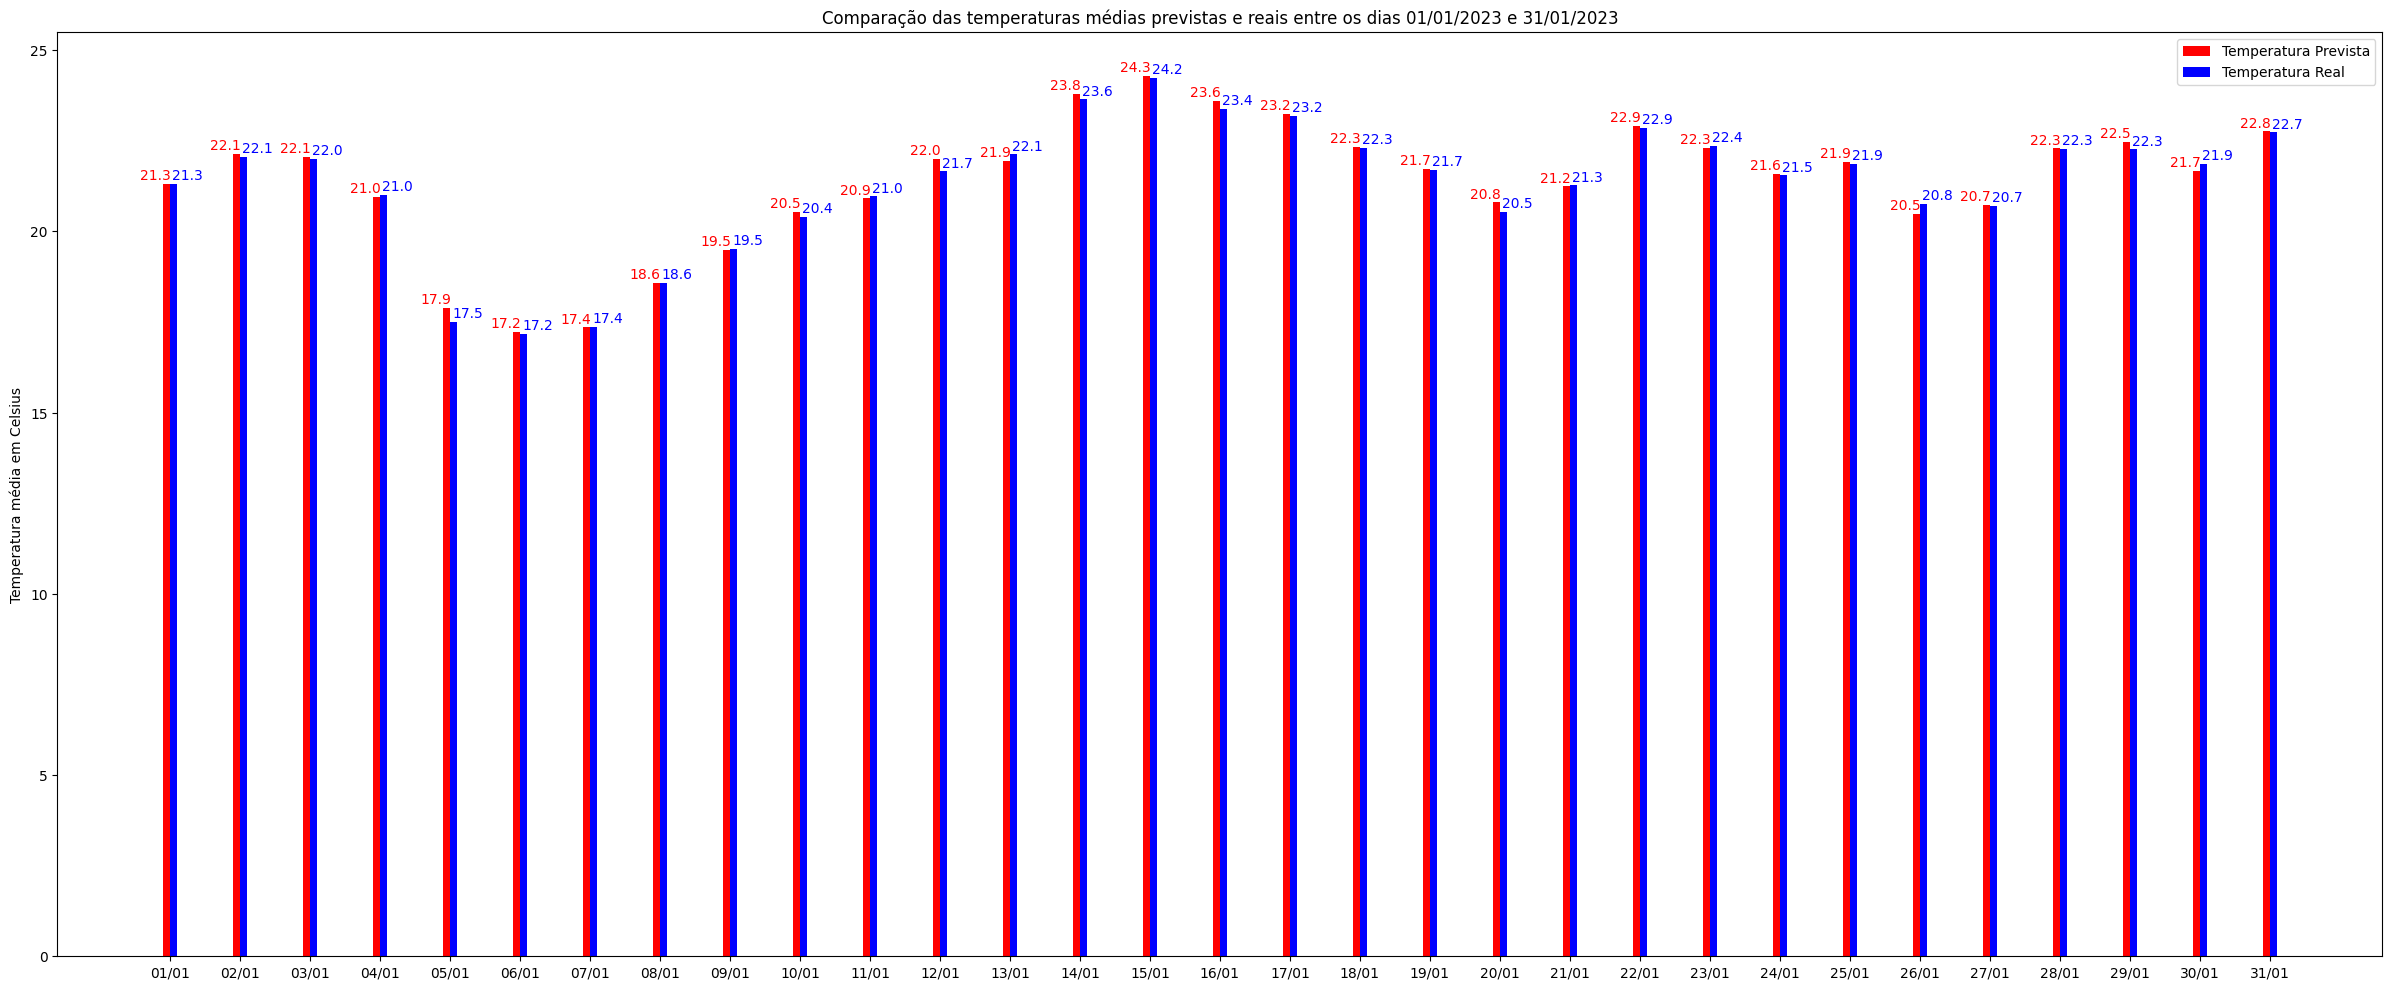

In [190]:
n = 31
largura = 0.1  

ind = np.arange(n)

fig, ax = plt.subplots(figsize=(30,12))
barras1 = ax.bar(ind, result["t_media_1"], largura, color='r', label='Temperatura Prevista')
barras2 = ax.bar(ind + largura, result["t_media_real"], largura, color='b', label='Temperatura Real')

ax.set_ylabel('Temperatura média em Celsius')
ax.set_title('Comparação das temperaturas médias previstas e reais entre os dias 01/01/2023 e 31/01/2023')
ax.set_xticks(ind + largura / 2)
ax.set_xticklabels(('01/01', '02/01', '03/01', '04/01', '05/01', '06/01', '07/01', '08/01', '09/01', '10/01', '11/01', '12/01', '13/01', '14/01', '15/01', '16/01', '17/01', '18/01', '19/01', '20/01', '21/01', '22/01', '23/01', '24/01', '25/01', '26/01', '27/01', '28/01', '29/01', '30/01', '31/01'))
ax.legend()

for barra in barras1:
    altura = barra.get_height()
    plt.annotate(f'{altura:.1f}', xy=(barra.get_x() + barra.get_width() / 2, altura), xytext=(-8, 1),
                textcoords="offset points", ha='center', va='bottom', color='r')

for barra in barras2:
    altura = barra.get_height()
    plt.annotate(f'{altura:.1f}', xy=(barra.get_x() + barra.get_width() / 2, altura), xytext=(10, 1),
                textcoords="offset points", ha='center', va='bottom', color='b')

plt.show()